In [31]:
import fitsio as fio
import numpy as np
import glob
from tqdm import tqdm

# Get a number of objects being cut at each selection. 

In [2]:
f_gold = fio.FITS('/pscratch/sd/m/myamamot/gold/all/gold_all_master.fits')
d_gold = f_gold[-1].read(columns=['RA', 'DEC', 'EXT_MASH'])
import healsparse
hmap = healsparse.HealSparseMap.read("/global/cfs/cdirs/des/y6-shear-catalogs/y6-combined-hleda-gaiafull-des-stars-hsmap16384-mdet-v4.fits")
footprint_map = healsparse.HealSparseMap.read("/global/cfs/cdirs/des/y6-shear-catalogs/y6a2_decasu_griz_nexpgt2_and_fp2_footprint.hsp")
gold_mask_map = healsparse.HealSparseMap.read("/global/cfs/cdirs/des/y6-shear-catalogs/y6a2_foreground_mask_healsparse_nside16384.fits.gz")

in_gold_footprint = footprint_map.get_values_pos(d_gold['RA'], d_gold['DEC'], valid_mask=True)
in_gold_mask = gold_mask_map.get_values_pos(d_gold['RA'], d_gold['DEC'], valid_mask=True)
in_mdet_footprint = hmap.get_values_pos(d_gold["RA"], d_gold["DEC"], valid_mask=True)

msk_mask = (in_mdet_footprint & in_gold_footprint & ~in_gold_mask)
d_gold = d_gold[msk_mask]
mdet_f = glob.glob('/global/cfs/cdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V5b/jackknife_patches_blinded/patch-*.fits')

In [4]:
# Get fraction
frac_tot = 0
num_tot = 0
match_mdet = 0
match_star = 0
# patch_name = [f.split('/')[-1][6:10] for f in mdet_f]
match_idx_f = sorted(glob.glob('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/basic/mdety6_goldy6_matched_idx_*.npy'))
match_d2d_f = sorted(glob.glob('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/basic/mdety6_goldy6_matched_d2d_*.npy'))
for j in tqdm(range(200)):
    idx=np.load(match_idx_f[j])
    d2d=np.load(match_d2d_f[j]) * 3600
    num_tot += len(idx)

    msk = d2d<(0.263)
    match_mdet += len(idx[msk])
    # print('match fraction: ', np.mean(msk))
    matched_gold = d_gold[idx[msk]]

    # print('high confidence star fraction: ', np.mean(matched_gold['EXT_MASH'] == 0)*100)
    # print('probably star fraction: ', np.mean(matched_gold['EXT_MASH'] == 1)*100)
    match_star += len(matched_gold[matched_gold['EXT_MASH'] == 0]) + len(matched_gold[matched_gold['EXT_MASH'] == 1])

print('total number of objects: ', num_tot)
print('how many fraction of mdet objects matched with gold: ', (match_mdet/num_tot)*100)
print('how many fraction of matched objects is stars: ', (match_star/match_mdet)*100)

100%|██████████| 200/200 [01:21<00:00,  2.46it/s]

total number of objects:  614781859
how many fraction of mdet objects matched with gold:  63.63287469742988
how many fraction of matched objects is stars:  8.388943070710255


In [17]:
len(mdet_f)

200

In [3]:
# Do the above excercise for each cut. 
selections = ["mask+sg+s2nsize+flux+junk"]#["mask", "mask+sg", "mask+sg+s2nsize", "mask+sg+s2nsize+flux", "mask+sg+s2nsize+flux+junk"]
num_all = 614781859#701292065
for selection in selections:
    print(selection)
    frac_tot = 0
    num_tot = 0
    match_mdet = 0
    match_star = 0
    # patch_name = [f.split('/')[-1][6:10] for f in mdet_f]
    match_idx_f = sorted(glob.glob('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/'+selection+'/mdety6_goldy6_matched_idx_*.npy'))
    match_d2d_f = sorted(glob.glob('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/'+selection+'/mdety6_goldy6_matched_d2d_*.npy'))
    for j in tqdm(range(200)):
        idx=np.load(match_idx_f[j])
        d2d=np.load(match_d2d_f[j]) * 3600
        num_tot += len(idx)

        msk = d2d<(0.263)
        match_mdet += len(idx[msk])
        # print('match fraction: ', np.mean(msk))
        matched_gold = d_gold[idx[msk]]

        # print('high confidence star fraction: ', np.mean(matched_gold['EXT_MASH'] == 0)*100)
        # print('probably star fraction: ', np.mean(matched_gold['EXT_MASH'] == 1)*100)
        match_star += len(matched_gold[matched_gold['EXT_MASH'] == 0]) + len(matched_gold[matched_gold['EXT_MASH'] == 1])

    print('total number of objects: ', num_tot)
    print('how many fraction of objects are removed: ', ((num_all-num_tot)/num_all)*100)
    print('how many fraction of mdet objects matched with gold: ', (match_mdet/num_tot)*100)
    print('how many fraction of matched objects is stars: ', (match_star/match_mdet)*100)
    
    num_all = num_tot

  1%|          | 2/200 [00:00<00:11, 17.95it/s]

mask+sg+s2nsize+flux+junk


100%|██████████| 200/200 [00:31<00:00,  6.35it/s]

total number of objects:  140021309
how many fraction of objects are removed:  77.22422889514702
how many fraction of mdet objects matched with gold:  89.13436239908313
how many fraction of matched objects is stars:  0.032433250733065265


# Match mdet with gold and estimate the fraction of stellar sample in our catalog.@10/18/2023

In [7]:
d_gold = []
f_gold = glob.glob('/pscratch/sd/m/myamamot/gold/all/gold_all_*.fits')
for f in f_gold:
    d = fio.read(f)
    d_gold.append(d)
d_gold = np.concatenate(d_gold)
fio.write('/pscratch/sd/m/myamamot/gold/all/gold_all_master.fits', d_gold)

In [8]:
# d = fio.read('/global/cfs/cdirs/des/myamamot/2pt_corr/v5b/y6_mdetV5_blindcat_v5cuts_nontomo.fits')
d_gold = fio.read('/pscratch/sd/m/myamamot/gold/all/gold_all_master.fits')

In [34]:
idx=np.load('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/gold_allcuts_shear_allcuts/mdety6_goldy6_matched_idx.npy')
d2d=np.load('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/gold_allcuts_shear_allcuts/mdety6_goldy6_matched_d2d.npy') * 3600

idx_hleda = np.load('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/mdety6_hleda_matched_idx.npy')
d2d_hleda = np.load('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/mdety6_hleda_matched_d2d.npy') * 3600

msk = (d2d<0.263)
print('match fraction: ', np.mean(msk))
rad = 110
msk_combined_hleda = ((d2d<0.263) & (d2d_hleda>rad))
print(len(d2d_hleda[d2d_hleda > rad]))
print('match fraction with more aggressive hyperleda cuts: ', np.mean(msk_combined_hleda))
# matched_gold = d_gold[idx[msk]]

# print('high confidence star fraction: ', np.mean(matched_gold['EXT_MASH'] == 0)*100)
# print('probably star fraction: ', np.mean(matched_gold['EXT_MASH'] == 1)*100)
# print('all star fraction: ', np.mean(((matched_gold['EXT_MASH'] == 0) | (matched_gold['EXT_MASH'] == 1)))*100)

match fraction:  0.8913436239908313
128319010
match fraction with more aggressive hyperleda cuts:  0.8177189230533476


0.03468222111821566


Text(0.5, 0, 'matched distance [arcsec]')

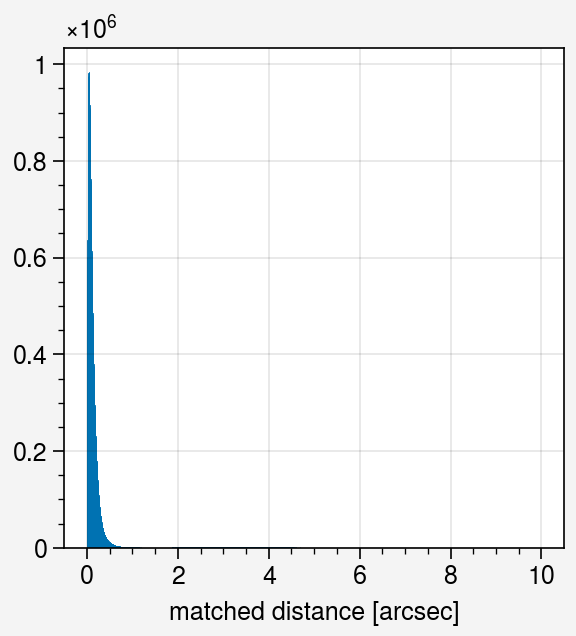

In [37]:
from matplotlib import pyplot as plt
import proplot as pplt
%matplotlib inline

print(np.mean(d2d>1))
fig,ax=pplt.subplots()
ax.hist(d2d,  bins=10000, range=[1e-5, 10])
ax.set_xlabel('matched distance [arcsec]', )

  0%|          | 0/100 [00:00<?, ?it/s]

140021309 140021309
match fraction:  0.9556985572817349


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Text(0, 0.5, 'match rate between gold and mdet')

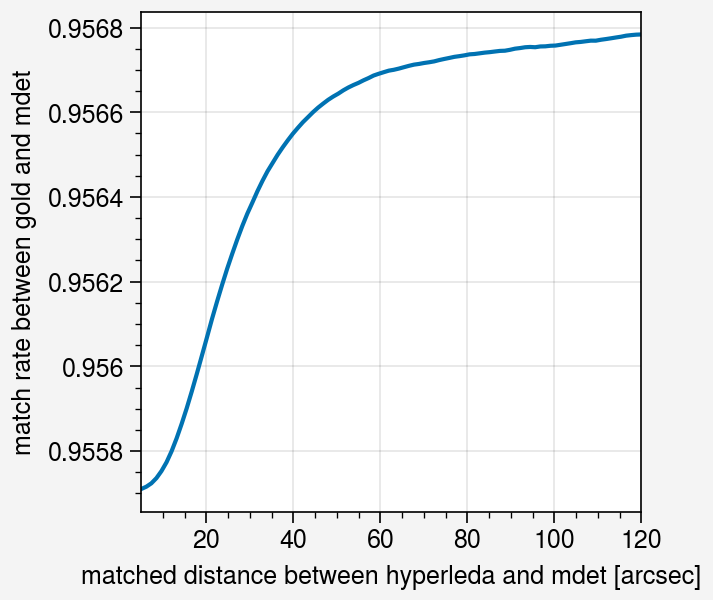

In [29]:
idx=np.load('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/gold_allcuts_shear_allcuts/mdety6_goldy6_matched_idx.npy')
d2d=np.load('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/gold_allcuts_shear_allcuts/mdety6_goldy6_matched_d2d.npy') * 3600

idx_hleda = np.load('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/mdety6_hleda_matched_idx.npy')
d2d_hleda = np.load('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/mdety6_hleda_matched_d2d.npy') * 3600
print(len(d2d), len(d2d_hleda))

msk = (d2d<0.526)
print('match fraction: ', np.mean(msk))
rad = np.linspace(5, 120, 100)
match_rate = []
for r in tqdm(rad):
    msk_combined_hleda = ((d2d_hleda>r) & (d2d<0.526))
    rate = np.sum(msk_combined_hleda)/np.sum(d2d_hleda>r)
    match_rate.append(rate)

fig,ax=pplt.subplots()
ax.plot(rad, match_rate)
ax.set_xlabel('matched distance between hyperleda and mdet [arcsec]', )
ax.set_ylabel('match rate between gold and mdet')

In [30]:
len(np.unique(idx_hleda))

162821

In [11]:
msk = d2d<(0.263)
print('match fraction: ', np.mean(msk))
matched_gold = d_gold[idx[msk]]

print('high confidence star fraction: ', np.mean(matched_gold['EXT_MASH'] == 0)*100)
print('probably star fraction: ', np.mean(matched_gold['EXT_MASH'] == 1)*100)

match fraction:  0.884370449654676
high confidence star fraction:  0.003537784933036534
probably star fraction:  0.0290224929216992


Text(0.5, 0, 'matched distance [arcsec]')

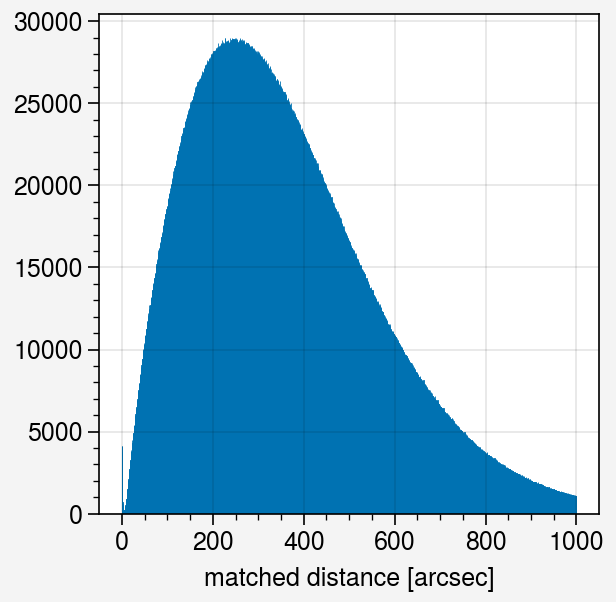

In [19]:
from matplotlib import pyplot as plt
import proplot as pplt
%matplotlib inline

d2d_hleda = np.load('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b_paper/goldmatch/mdety6_hleda_matched_d2d.npy') * 3600
fig,ax=pplt.subplots()
ax.hist(d2d_hleda,  bins=10000, range=[1e-5, 1000])
ax.set_xlabel('matched distance [arcsec]', )

In [4]:
np.mean(d2d < 0.52)

0.9748962495415608

In [24]:
msk = (matched_gold['EXT_MASH'] == 2)
d_ = d[msk]

In [1]:
import h5py as h5
import fitsio as fio
import numpy as np
import glob
from tqdm import tqdm
fs = sorted(glob.glob('/global/cfs/cdirs/des/myamamot/metadetect/Y6A2_METADETECT_V5b/patch-*.fits'))

steps = []
for patch in tqdm(fs):
    step = fio.read(patch)['mdet_step']
    steps.append(step)
steps = np.concatenate(steps)
np.save('/global/cfs/cdirs/des/myamamot/metadetect/Y6A2_METADETECT_V5b/mdet_steps.npy', steps)

  8%|▊         | 15/200 [00:57<11:50,  3.84s/it]


KeyboardInterrupt: 

In [ ]:
import h5py as h5
import pickle
from tqdm import tqdm
dered_h5 = h5.File('/global/cfs/cdirs/des/myamamot/metadetect/Y6A2_METADETECT_V5b/metadetect_desdmv5a_cutsv5_dereddened.h5', 'w') 
with open('/global/cfs/cdirs/des/myamamot/metadetect/Y6A2_METADETECT_V5b/patch-data.pickle', 'rb') as f:
    d = pickle.load(f)
keys = d['noshear'].dtype.names
    
for j in ['noshear/','1p/','1m/','2p/','2m/']:
    for k in tqdm(keys):
        dered_h5.create_dataset('mdet/'+j+k, data = d[j[:-1]] )
dered_h5.close()

In [ ]:
import scipy.stats
n_jck=300
plot_dict_old=load_obj('everything_you_need_for_ABE_focal_plane')
plot_dict=load_obj('everything_you_need_for_ABE_focal_plane_unbl_new')
path_save = '/global/u2/m/mgatti/Cosmic_Shear/Y3_shearcat_tests/Additive/'


fig, ax = plt.subplots(1,2,sharex = True, figsize=(10,3.5))

ax[0].plot(np.array([-0.03,0.03]),0*np.array([-0.0007,0.0007]),color='grey',alpha=0.5)
ax[1].plot(np.array([-0.03,0.03]),0*np.array([-0.0007,0.0007]),color='grey',alpha=0.5)

#****************************
duv = plot_dict_old['fit_dict']['e1psf_e1_Y1']
ax[0].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o',alpha = 0.6,label = 'Y1' ,markersize=7,markerfacecoloralt=colors[0],color=colors[0],fillstyle='none')
duv = plot_dict['fit_dict']['e1psf_e1']

path = path_save+'/output_jk/e1_{0}_{1}'.format('psf_e1',n_jck)
duv = load_obj(path)

ax[0].errorbar(duv['x0'],duv['vec']-duv['mut'][0][0][1],duv['err'],label = 'Y3',fmt='D',markersize=5,markerfacecoloralt=colors[1],color=colors[1],fillstyle='none')
b_=duv['mut'][0][0][0]
print (b_,np.sqrt(duv['mut'][0][1][0,0]))
ax[0].plot(duv['x0'],b_*(duv['x0']),alpha = 0.5,color='black',label='linear fit')

b_ =  plot_dict['dict_slopes']['e1psf_e1'][0]
ax[0].plot(duv['x0'],b_*(duv['x0']),alpha = 0.5,color=colors[2],linestyle='dashed',label=r'from $\rho$ stats.')
#ax[0].fill_between(x0, (b_+dus['err'])*(x0-xmm),(b_-dus['err'])*(x0-xmm),alpha = 0.5,color="red",label="focal plane coord.")









#****************************
duv = plot_dict_old['fit_dict']['e2psf_e2_Y1']
ax[1].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o', alpha = 0.6,label = 'Y1' ,markersize=7,markerfacecoloralt=colors[0],color=colors[0],fillstyle='none')

path = path_save+'/output_jk/e2_{0}_{1}'.format('psf_e2',n_jck)
duv = load_obj(path)
ax[1].errorbar(duv['x0'],duv['vec']-duv['mut'][0][0][1],duv['err'],label = 'Y3',fmt='D',markersize=5,markerfacecoloralt=colors[1],color=colors[1],fillstyle='none')

b_=duv['mut'][0][0][0]
print (b_,np.sqrt(duv['mut'][0][1][0,0]))
ax[1].plot(duv['x0'],b_*(duv['x0']),alpha = 0.5,color='black',label='linear fit')
#ax[0].fill_between(duv['x0'], (b_+np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),(b_-np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),alpha = 0.5,color="black",label="real plane coord.")
b_ =  plot_dict['dict_slopes']['e2psf_e2'][0]
ax[1].plot(duv['x0'],b_*(duv['x0']),alpha = 0.5,color=colors[2],linestyle='dashed',label=r'from $\rho$ stats.')
#ax[1].fill_between(duv['x0'], (b_+np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),(b_-np.sqrt(duv['mut'][1][0,0]))*(duv['x0']-duv['xmm']),alpha = 0.5,color="black",label="real plane coord.")



ax[1].legend(loc="upper right", bbox_to_anchor=(1.2,1.2),fontsize=13,framealpha=1)

ax[0].set_ylabel(r"$\langle e_1 \rangle$",size=15)
ax[1].set_ylabel(r"$\langle e_2 \rangle$",size=15)
ax[0].set_xlabel(r"${\rm PSF}_1$",size=15)
ax[1].set_xlabel(r"${\rm PSF}_2$",size=15)
ax[1].set_ylim([-0.0015,0.0015])
ax[0].set_ylim([-0.0015,0.0015])


ax[1].set_xlim([-0.03,0.03])
ax[0].set_xlim([-0.03,0.03])
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig('./figures/e_PSF_y3y1.pdf',bbox_inches='tight')
plt.show()




fig, ax = plt.subplots(1,2,sharex = True, figsize=(10,3.5))


#****************************
duv = plot_dict_old['fit_dict']['e1psf_size_Y1']
ax[0].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o',alpha = 0.6,label = 'Y1' ,markersize=7,markerfacecoloralt=colors[0],color=colors[0],fillstyle='none')

path = path_save+'/output_jk/e1_{0}_{1}'.format('psf_T',n_jck)
duv = load_obj(path)
ax[0].errorbar(duv['x0'],duv['vec']-duv['mut'][0][0][1],duv['err'],label = 'Y3',fmt='D',markersize=5,markerfacecoloralt=colors[1],color=colors[1],fillstyle='none')

#****************************
duv = plot_dict_old['fit_dict']['e2psf_size_Y1']
ax[1].errorbar(duv['x0'],duv['vec'],duv['err'],fmt='o',alpha = 0.6,label = 'Y1' ,markersize=7,markerfacecoloralt=colors[0],color=colors[0],fillstyle='none')

path = path_save+'/output_jk/e2_{0}_{1}'.format('psf_T',n_jck)
duv = load_obj(path)
ax[1].errorbar(duv['x0'],duv['vec']-duv['mut'][0][0][1],duv['err'], label = 'Y3',fmt='D',markersize=5,markerfacecoloralt=colors[1],color=colors[1],fillstyle='none')



ax[1].legend(loc="upper right", bbox_to_anchor=(1.2,1.2),fontsize=13,framealpha=1)

ax[0].set_ylabel(r"$\langle e_1 \rangle$",size=15)
ax[1].set_ylabel(r"$\langle e_2 \rangle$",size=15)
ax[0].set_xlabel(r"${\rm T_{\rm PSF}}$",size=15)
ax[1].set_xlabel(r"${\rm T_{\rm PSF}}$",size=15)
ax[1].set_ylim([-0.0007,0.0007])
ax[0].set_ylim([-0.0007,0.0007])
ax[0].plot(np.array([0.2,0.65]),0*np.array([-0.0007,0.0007]),color='grey',alpha=0.5)
ax[1].plot(np.array([0.2,0.65]),0*np.array([-0.0007,0.0007]),color='grey',alpha=0.5)
ax[1].set_xlim([0.2,0.65])
ax[0].set_xlim([0.2,0.65])
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig('./figures/e_PSFsize_y3y1.pdf',bbox_inches='tight')
plt.show()

In [1]:
import pickle
with open('/global/homes/m/mgatti/Cosmic_Shear/Y3_shearcat_tests/final_plots_paper/everything_you_need_for_ABE_focal_plane_unbl_new.pkl', 'rb') as f:
    d = pickle.load(f)

UnicodeDecodeError: 'ascii' codec can't decode byte 0x85 in position 0: ordinal not in range(128)

In [13]:
x = d['fit_dict']['e1psf_e1']['x0']


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [14]:
d['fit_dict'].keys()

dict_keys(['e1psf_e1', 'e2psf_e2', 'e1psf_size_', 'e2psf_size_'])

# Check survey inhomogeneity

In [24]:
import fitsio as fio
import h5py as h5
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import proplot as pplt
import skyproj
%matplotlib inline

In [25]:
f_som = '/global/cfs/cdirs/des/acampos/sompz_output/y6_data_preliminary/sompz_y6_data_preliminary.hdf5'
redshift_data = h5.File(f_som, 'r')
msk1 = (redshift_data['catalog']['sompz']['noshear']['bhat'][:] == 0)
msk4 = (redshift_data['catalog']['sompz']['noshear']['bhat'][:] == 3)

f = '/global/cfs/cdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V5a/metadetect_desdmv5a_cutsv5.h5'
mdet_data = h5.File(f, 'r')
d = mdet_data.get('/mdet/noshear')
ra_bin1 = np.array(d['ra'])[msk1]
dec_bin1 = np.array(d['dec'])[msk1]
ra_bin4 = np.array(d['ra'])[msk4]
dec_bin4 = np.array(d['dec'])[msk4]

In [40]:
import healpy as hp
import healsparse as hsp
nside_coverage = 128
nside_sparse = 128

desy6_map_bin1 = np.zeros(hp.nside2npix(nside_sparse))
pix = hp.ang2pix(nside_sparse, ra_bin1, dec_bin1, lonlat=True, nest=True)
unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
desy6_map_bin1[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))

desy6_map_bin4 = np.zeros(hp.nside2npix(nside_sparse))
pix = hp.ang2pix(nside_sparse, ra_bin4, dec_bin4, lonlat=True, nest=True)
unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
desy6_map_bin4[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))


res = desy6_map_bin4/desy6_map_bin1 # (hp.pixelfunc.nside2pixarea(nside_sparse,degrees=True)*(60*60))
hsp_map = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=res)
hsp_map_bin4 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=desy6_map_bin4/(hp.pixelfunc.nside2pixarea(nside_sparse,degrees=True)*(60*60)))
hsp_map_bin1 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=desy6_map_bin1/(hp.pixelfunc.nside2pixarea(nside_sparse,degrees=True)*(60*60)))

<ipython-input-40-5f1126e4e17a>:17: RuntimeWarning: divide by zero encountered in true_divide
  res = desy6_map_bin4/desy6_map_bin1 # (hp.pixelfunc.nside2pixarea(nside_sparse,degrees=True)*(60*60))
<ipython-input-40-5f1126e4e17a>:17: RuntimeWarning: invalid value encountered in true_divide
  res = desy6_map_bin4/desy6_map_bin1 # (hp.pixelfunc.nside2pixarea(nside_sparse,degrees=True)*(60*60))


<ipython-input-41-c38929115014>:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


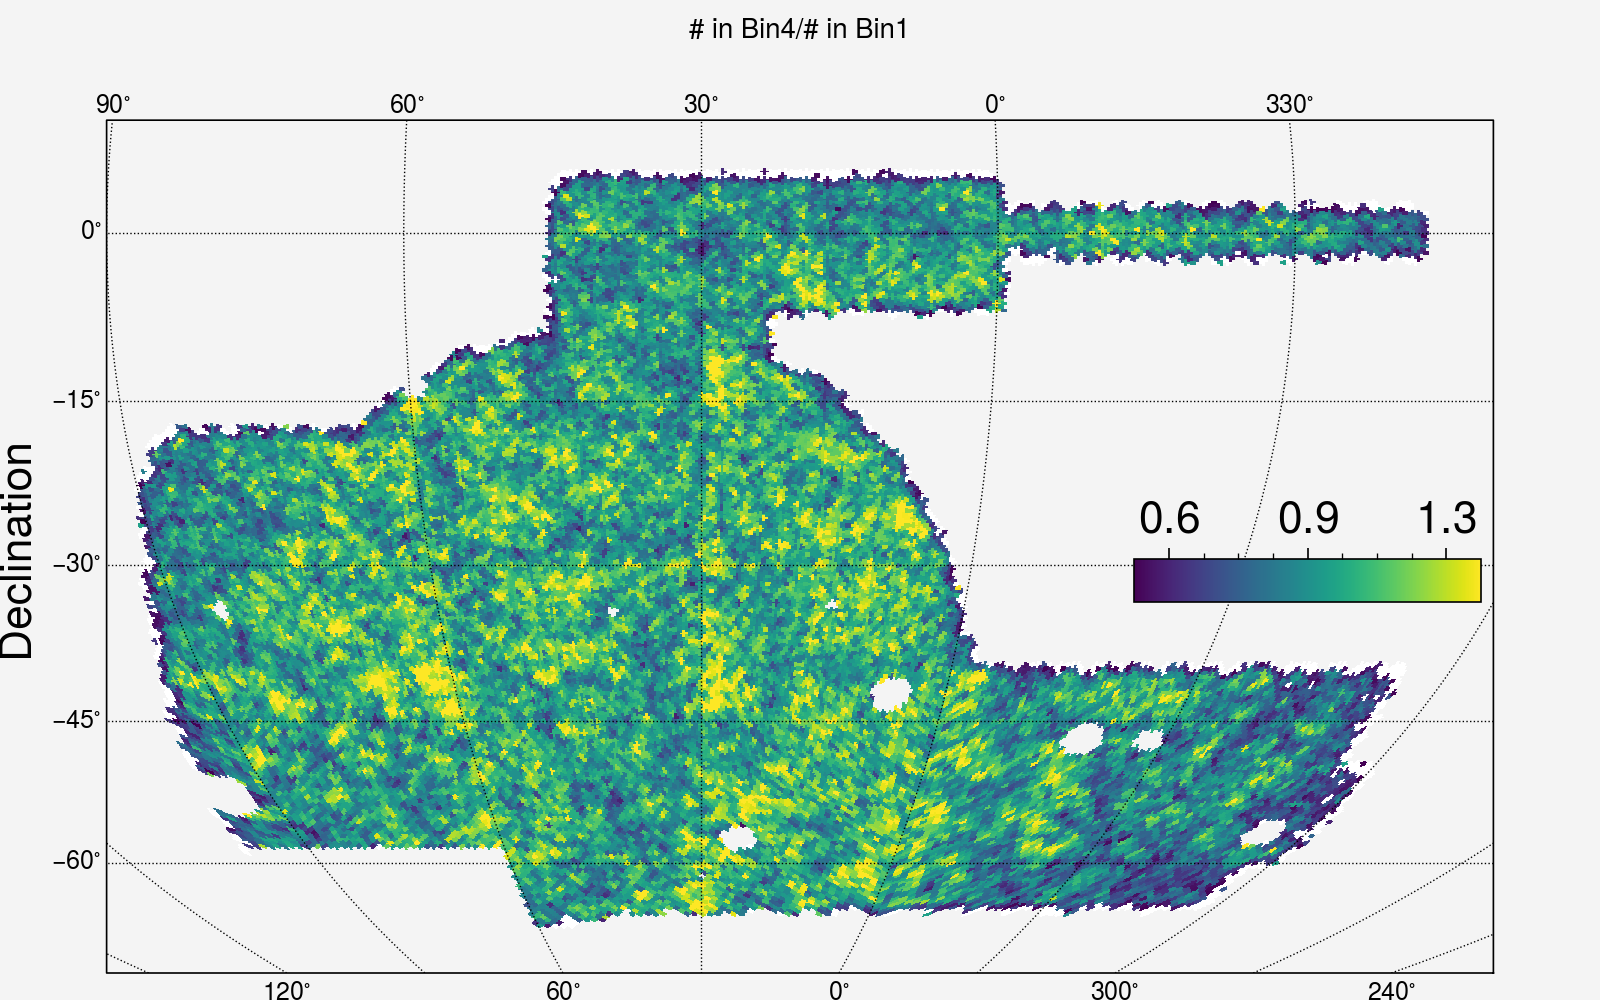

In [41]:
fig,ax = plt.subplots(figsize=(8,5))
my_cmap = matplotlib.cm.get_cmap('viridis')
my_cmap.set_under('white')
m = skyproj.DESSkyproj(ax=ax)
m.draw_des(label='DES', edgecolor='none',)
_ = m.draw_hspmap(hsp_map, cmap=my_cmap, zoom=False)
m.draw_inset_colorbar(fontsize=16)
plt.title('# in Bin4/# in Bin1', y=1.08)
plt.tight_layout()

<ipython-input-38-b7354671bb86>:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


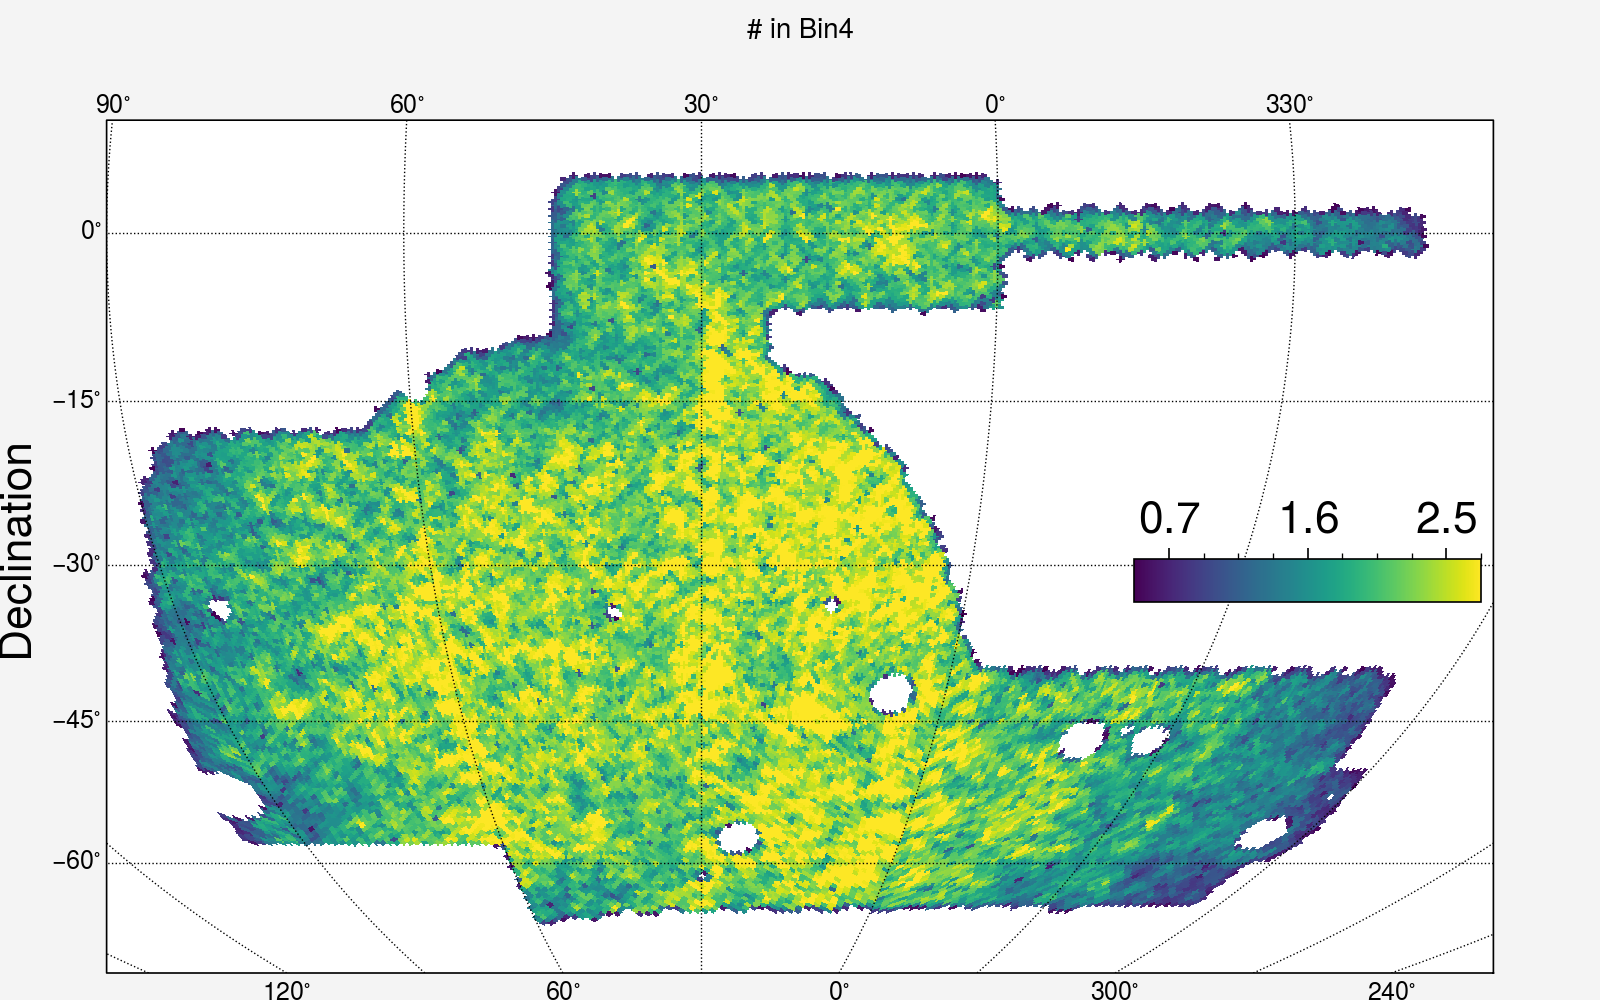

In [38]:
fig,ax = plt.subplots(figsize=(8,5))
my_cmap = matplotlib.cm.get_cmap('viridis')
my_cmap.set_under('white')
m = skyproj.DESSkyproj(ax=ax)
m.draw_des(label='DES', edgecolor='none',)
_ = m.draw_hspmap(hsp_map_bin4, cmap=my_cmap, zoom=False, vmin=0.5)
m.draw_inset_colorbar(fontsize=16,)
plt.title('# in Bin4', y=1.08)
plt.tight_layout()

In [63]:
# non-uniform
cardinal_redshift_ = h5.File('/pscratch/sd/c/chto100/Cardinalv3/Y6a_v6_test_v8_nonuniform/Cardinal-3_v2.0_Y6a_sompz_v0.25.h5','r')
print(len(cardinal_redshift_['/catalog/sompz/unsheared/coadd_object_id'][:]))

msk1_ = (cardinal_redshift_['catalog']['sompz']['unsheared']['bhat'][:] == 0)
msk4_ = (cardinal_redshift_['catalog']['sompz']['unsheared']['bhat'][:] == 3)

f = '/pscratch/sd/c/chto100/Cardinalv3/Y6a_v6_test_v8_nonuniform/Cardinal-3_v2.0_Y6a_shape.h5'
cardinal_data = h5.File(f, 'r')
d = cardinal_data.get('/catalog/unsheared/metacal/')
ra_bin1 = np.array(d['ra'])[msk1_]
dec_bin1 = np.array(d['dec'])[msk1_]
ra_bin4 = np.array(d['ra'])[msk4_]
dec_bin4 = np.array(d['dec'])[msk4_]

1399546088


<ipython-input-64-813d59bda8f8>:16: RuntimeWarning: divide by zero encountered in true_divide
  res_nonuniform = cardinal_map_bin4/cardinal_map_bin1 # (hp.pixelfunc.nside2pixarea(nside_sparse,degrees=True)*(60*60))
<ipython-input-64-813d59bda8f8>:16: RuntimeWarning: invalid value encountered in true_divide
  res_nonuniform = cardinal_map_bin4/cardinal_map_bin1 # (hp.pixelfunc.nside2pixarea(nside_sparse,degrees=True)*(60*60))
<ipython-input-64-813d59bda8f8>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


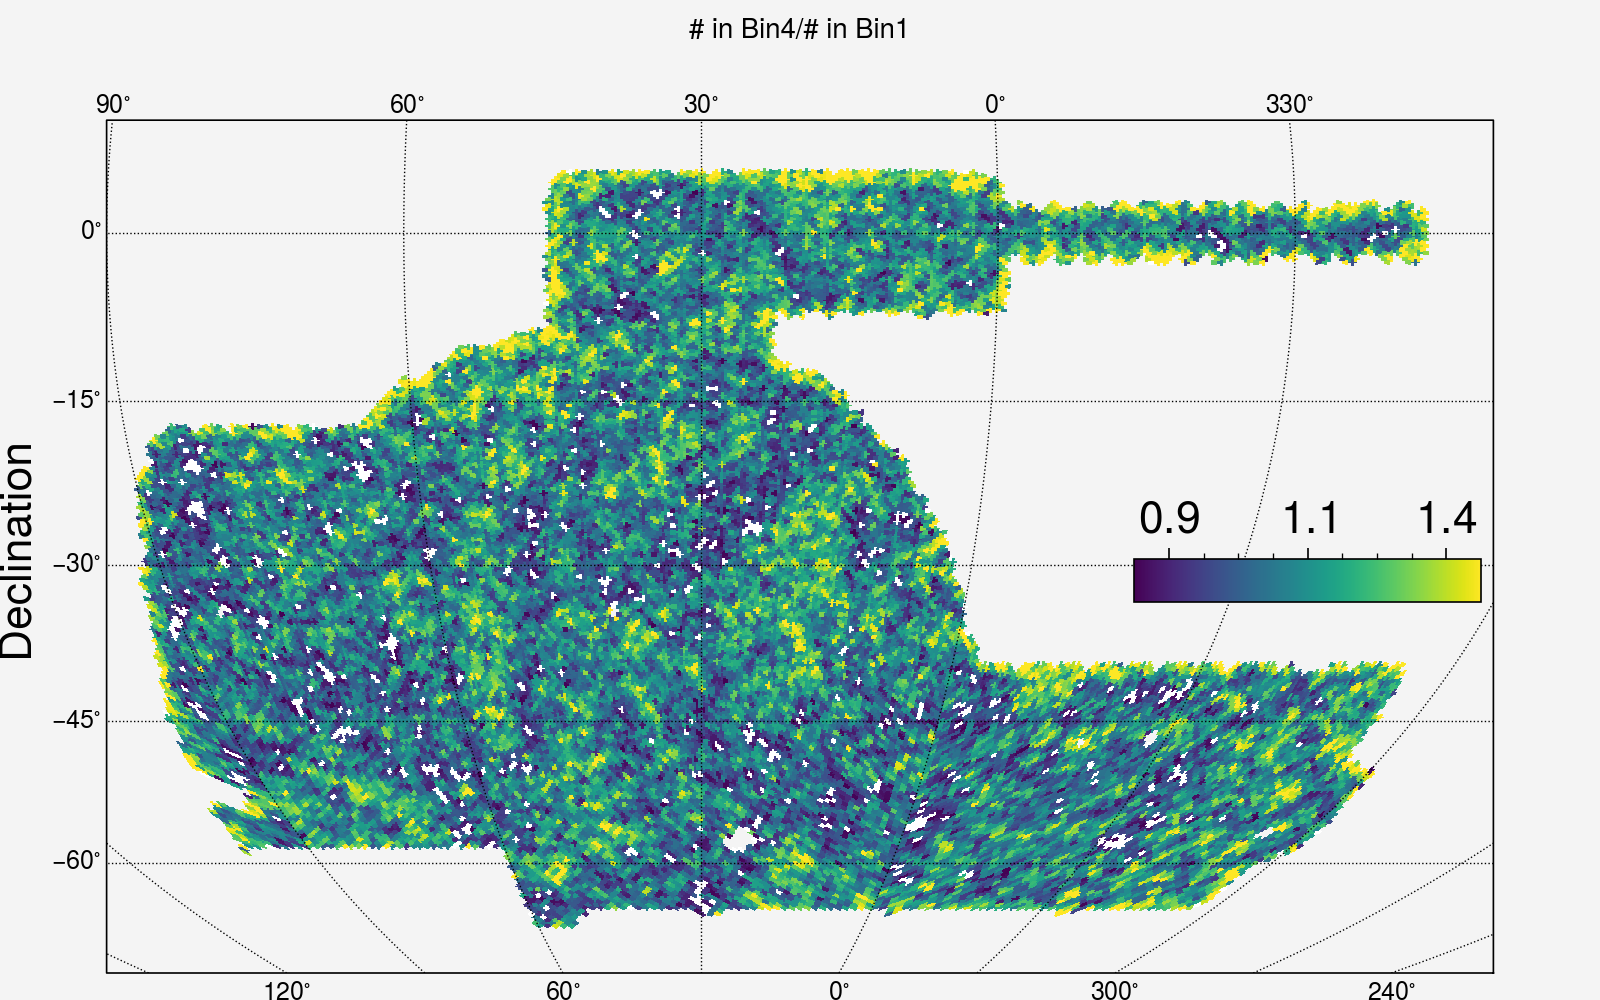

In [64]:
import healpy as hp
import healsparse as hsp
nside_coverage = 128
nside_sparse = 128

cardinal_map_bin1 = np.zeros(hp.nside2npix(nside_sparse))
pix = hp.ang2pix(nside_sparse, ra_bin1, dec_bin1, lonlat=True, nest=True)
unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
cardinal_map_bin1[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))

cardinal_map_bin4 = np.zeros(hp.nside2npix(nside_sparse))
pix = hp.ang2pix(nside_sparse, ra_bin4, dec_bin4, lonlat=True, nest=True)
unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
cardinal_map_bin4[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))

res_nonuniform = cardinal_map_bin4/cardinal_map_bin1 # (hp.pixelfunc.nside2pixarea(nside_sparse,degrees=True)*(60*60))
cardinal_map_nonuniform = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=res_nonuniform)

fig,ax = plt.subplots(figsize=(8,5))
my_cmap = matplotlib.cm.get_cmap('viridis')
my_cmap.set_under('white')
m = skyproj.DESSkyproj(ax=ax)
m.draw_des(label='DES', edgecolor='none',)
_ = m.draw_hspmap(cardinal_map_nonuniform, cmap=my_cmap, zoom=False)
m.draw_inset_colorbar(fontsize=16)
plt.title('# in Bin4/# in Bin1', y=1.08)
plt.tight_layout()

In [65]:
# uniform
cardinal_redshift_ = h5.File('/pscratch/sd/c/chto100/Cardinalv3/Y6a_v6_test_v8/Cardinal-3_v2.0_Y6a_sompz_v0.25.h5','r')
print(len(cardinal_redshift_['/catalog/sompz/unsheared/coadd_object_id'][:]))

msk1_ = (cardinal_redshift_['catalog']['sompz']['unsheared']['bhat'][:] == 0)
msk4_ = (cardinal_redshift_['catalog']['sompz']['unsheared']['bhat'][:] == 3)

f = '/pscratch/sd/c/chto100/Cardinalv3/Y6a_v6_test_v8/Cardinal-3_v2.0_Y6a_shape.h5'
cardinal_data = h5.File(f, 'r')
d = cardinal_data.get('/catalog/unsheared/metacal/')
ra_bin1 = np.array(d['ra'])[msk1_]
dec_bin1 = np.array(d['dec'])[msk1_]
ra_bin4 = np.array(d['ra'])[msk4_]
dec_bin4 = np.array(d['dec'])[msk4_]

1399546088


<ipython-input-66-59f22b4012f0>:11: RuntimeWarning: divide by zero encountered in true_divide
  res_uniform = cardinal_map_bin4/cardinal_map_bin1 # (hp.pixelfunc.nside2pixarea(nside_sparse,degrees=True)*(60*60))
<ipython-input-66-59f22b4012f0>:11: RuntimeWarning: invalid value encountered in true_divide
  res_uniform = cardinal_map_bin4/cardinal_map_bin1 # (hp.pixelfunc.nside2pixarea(nside_sparse,degrees=True)*(60*60))
<ipython-input-66-59f22b4012f0>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


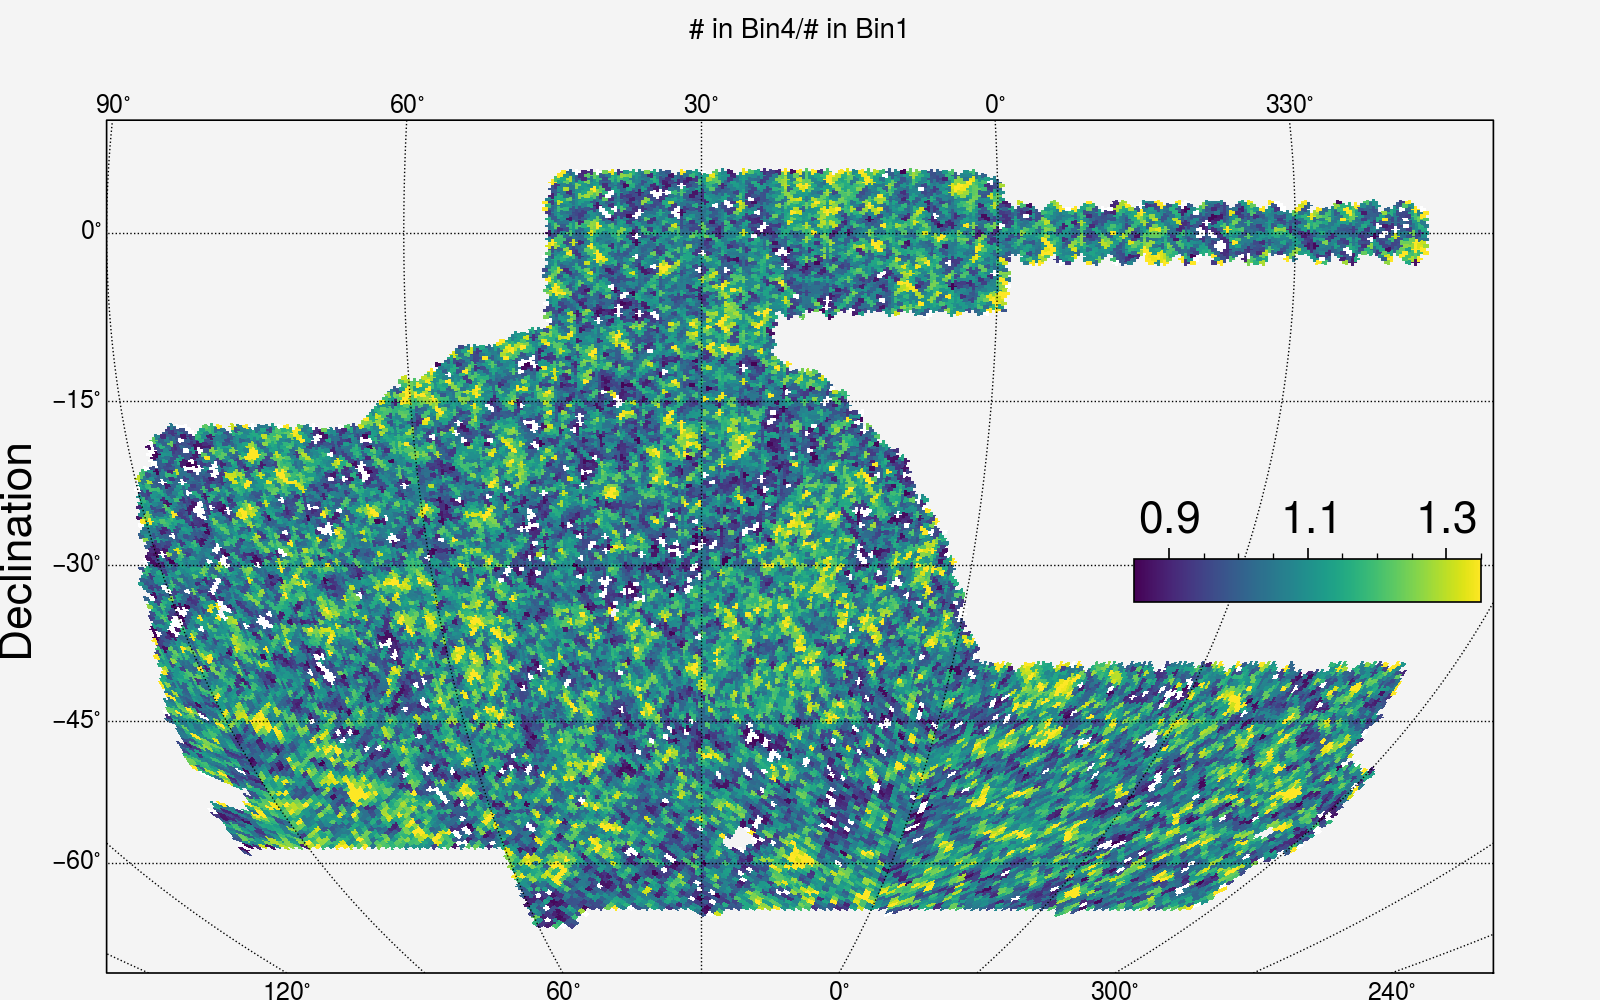

In [66]:

cardinal_map_bin1 = np.zeros(hp.nside2npix(nside_sparse))
pix = hp.ang2pix(nside_sparse, ra_bin1, dec_bin1, lonlat=True, nest=True)
unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
cardinal_map_bin1[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))

cardinal_map_bin4 = np.zeros(hp.nside2npix(nside_sparse))
pix = hp.ang2pix(nside_sparse, ra_bin4, dec_bin4, lonlat=True, nest=True)
unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
cardinal_map_bin4[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))

res_uniform = cardinal_map_bin4/cardinal_map_bin1 # (hp.pixelfunc.nside2pixarea(nside_sparse,degrees=True)*(60*60))
cardinal_map_uniform = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=res_uniform)

fig,ax = plt.subplots(figsize=(8,5))
my_cmap = matplotlib.cm.get_cmap('viridis')
my_cmap.set_under('white')
m = skyproj.DESSkyproj(ax=ax)
m.draw_des(label='DES', edgecolor='none',)
_ = m.draw_hspmap(cardinal_map_uniform, cmap=my_cmap, zoom=False)
m.draw_inset_colorbar(fontsize=16)
plt.title('# in Bin4/# in Bin1', y=1.08)
plt.tight_layout()

# Check SV shear data

In [3]:
import fitsio as fio
import numpy as np
import os,sys
import h5py as h5

In [5]:
path = '/global/cfs/cdirs/des/www/y3_cats/Y3_mastercat___UNBLIND___final_v1.1_12_22_20.h5'
m = h5.File(path,'r')
# load mask
mask = np.array(m.get('/index/select'))

# Load weights
w = np.array(m.get('/catalog/metacal/unsheared/weight'))
w_1p = np.array(m.get('/catalog/metacal/sheared_1p/weight'))
w_2p = np.array(m.get('/catalog/metacal/sheared_2p/weight'))
w_1m = np.array(m.get('/catalog/metacal/sheared_1m/weight'))
w_2m = np.array(m.get('/catalog/metacal/sheared_2m/weight'))

# load sheared ellipticities
e1_1m = np.array(m.get('/catalog/metacal/sheared_1m/e_1'))
e1_1p = np.array(m.get('/catalog/metacal/sheared_1p/e_1'))
e2_2m = np.array(m.get('/catalog/metacal/sheared_2m/e_2'))
e2_2p = np.array(m.get('/catalog/metacal/sheared_2p/e_2'))

# compute responses
dg = 0.01
m1   = (np.average(e1_1p[mask],weights = w_1p[mask]) - np.average(e1_1m[mask],weights = w_1m[mask])) / (2.*dg)
m2   = (np.average(e2_2p[mask],weights = w_2p[mask]) - np.average(e2_2m[mask],weights = w_2m[mask])) / (2.*dg)

print ('rg',m1,m2)

# compute selection responses
# load sheared masks
mask_1m = np.array(m['index']['select_1m'])
mask_1p = np.array(m['index']['select_1p'])
mask_2m = np.array(m['index']['select_2m'])
mask_2p = np.array(m['index']['select_2p'])

# Load ellipticities
e1 = np.array(m.get('/catalog/metacal/unsheared/e_1'))
e2 = np.array(m.get('/catalog/metacal/unsheared/e_2'))

d_m1   = (np.average(e1[mask_1p],weights = w[mask_1p]) - np.average(e1[mask_1m],weights = w[mask_1m])) / (2.*dg)
d_m2   = (np.average(e2[mask_2p],weights = w[mask_2p]) - np.average(e2[mask_2m],weights = w[mask_2m])) / (2.*dg)
print ('rg+rs',m1+d_m1,m2+d_m2)

# you can also simply use the average responses in the catalogs, but they will be slightly less accurate,
# because they are defined as R11 =(e1_1p[mask] -e1_1m[mask]) / (2.*dg), whereas ideally you'd want to
# use the sheared weights as well. The difference is very small, though...
# Load responses
R1 = np.array(m.get('/catalog/metacal/unsheared/R11'))
R2 = np.array(m.get('/catalog/metacal/unsheared/R22'))
R1 = R1[mask]
R2 = R2[mask]

m1_   = np.average(R1,weights = w[mask])
m2_   = np.average(R2,weights = w[mask])
print ('rg',m1_,m2_)

# add responses together
m1   = (m1+d_m1)*np.ones(len(mask))
m2   = (m2+d_m2)*np.ones(len(mask))
s   = (m1+m2)/2. 

rg 0.7096703611630152 0.7110857885006183
rg+rs 0.7175106173257537 0.719262760176361
rg 0.7086199762729599 0.7098185112945081


In [2]:
wlinfo = fio.read('/pscratch/sd/m/myamamot/y6-cosmicshear/sva1_gold_r1.0_wlinfo.fits.gz')
shearinfo = fio.read('/pscratch/sd/m/myamamot/y6-cosmicshear/sva1_gold_r1.0_ngmix.fits.gz')

In [ ]:
f = h5.File('/global/cfs/cdirs/des/www/y3_cats/Y3_mastercat___UNBLIND___final_v1.1_12_22_20.h5', 'r')
m = np.array(f.get('/index/select'))

In [3]:
print(wlinfo.dtype, len(wlinfo))
print(shearinfo.dtype, len(shearinfo))

[('COADD_OBJECTS_ID', '>i8'), ('RA', '>f8'), ('DEC', '>f8'), ('MAG_AUTO_G', '>f4'), ('MAG_AUTO_R', '>f4'), ('MAG_AUTO_I', '>f4'), ('MAG_AUTO_Z', '>f4'), ('PHOTOZ_BIN', '>i4'), ('MEAN_PHOTOZ', '>f4'), ('SVA1_FLAG', '>i4'), ('IM3SHAPE_FLAG', '>i4'), ('NGMIX_FLAG', '>i4')] 25227559
[('COADD_OBJECTS_ID', '>i8'), ('E_1', '>f8'), ('E_2', '>f8'), ('SENS_AVG', '>f8'), ('W', '>f8'), ('E_COV_1_1', '>f8'), ('E_COV_1_2', '>f8'), ('E_COV_2_1', '>f8'), ('E_COV_2_2', '>f8'), ('ERROR_FLAG', '>i4'), ('SNR_W', '>f4'), ('SNR_R', '>f4'), ('FLUX_I', '>f4'), ('MAG_I', '>f4'), ('T', '>f4'), ('T_ERR', '>f4'), ('T_R', '>f4'), ('SNR_T', '>f4'), ('SNR_T_R', '>f4'), ('LOG10_SB_I', '>f4'), ('MEAN_PSF_E1', '>f8'), ('MEAN_PSF_E2', '>f8'), ('MEAN_PSF_T', '>f4'), ('SENS_1', '>f4'), ('SENS_2', '>f4'), ('ARATE', '>f4'), ('STAMP_SIZE', '>i4'), ('MASK_FRAC', '>f4')] 25227559


In [6]:
msk = ((wlinfo['SVA1_FLAG'] == 0) & (wlinfo['NGMIX_FLAG'] == 0))

e1 = shearinfo['E_1'][msk]
e2 = shearinfo['E_2'][msk]
w = shearinfo['W'][msk]
ra = wlinfo['RA'][msk]
dec = wlinfo['DEC'][msk]

In [6]:
e1 = np.array(m.get('/catalog/metacal/unsheared/e_1'))[mask]
e2 = np.array(m.get('/catalog/metacal/unsheared/e_2'))[mask]
ra = np.array(m.get('/catalog/metacal/unsheared/ra'))[mask]
dec = np.array(m.get('/catalog/metacal/unsheared/dec'))[mask]

In [ ]:
import treecorr

cat = treecorr.Catalog(g1=e1/s,g2=e2/s,w=w[mask],ra=ra,dec=dec,ra_units='deg',dec_units='deg',flip_g2=False,)
gg = treecorr.GGCorrelation(nbins=20,min_sep=2.5,max_sep=250,sep_units='arcmin',bin_slop=0.0,output_dots=False,verbose=True)
gg.process(cat, cat, low_mem=True)

In [ ]:
gg.write('/pscratch/sd/m/myamamot/y6-cosmicshear/y3_gg_nontomo.fits')
# cov_boot = gg.estimate_cov('bootstrap')
# np.save('/pscratch/sd/m/myamamot/y6-cosmicshear/sva1_gg_nontomo_cov_boot.npy', cov_boot)

In [ ]:
from matplotlib import pyplot as plt
import proplot as pplt
import matplotlib
%matplotlib inline

xi_sv = np.loadtxt('/pscratch/sd/m/myamamot/y6-cosmicshear/ngmix_xi_nontomo.dat')
xi_cov_sv = np.loadtxt('/pscratch/sd/m/myamamot/y6-cosmicshear/ngmix_xi_cov_nontomo.dat')

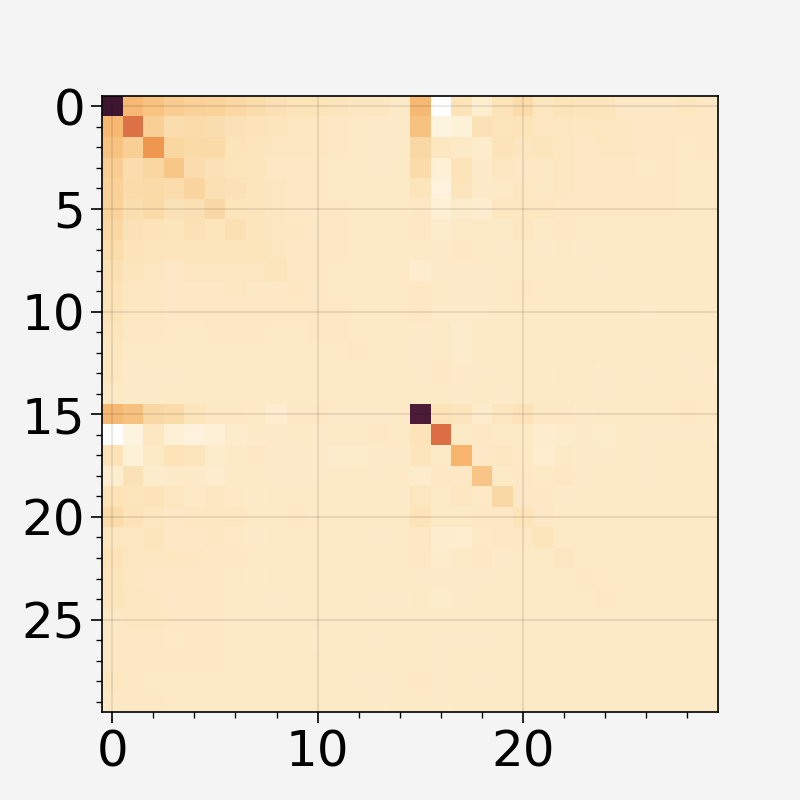

In [34]:
xi_cov = xi_cov_sv[:,2].reshape((30,30))
plt.imshow(xi_cov, )

/global/homes/m/myamamot/miniforge3/envs/eastlake-dev/lib/python3.8/site-packages/proplot/axes/cartesian.py:646: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)


Text(0, 0.5, '$\\xi_{+}$')

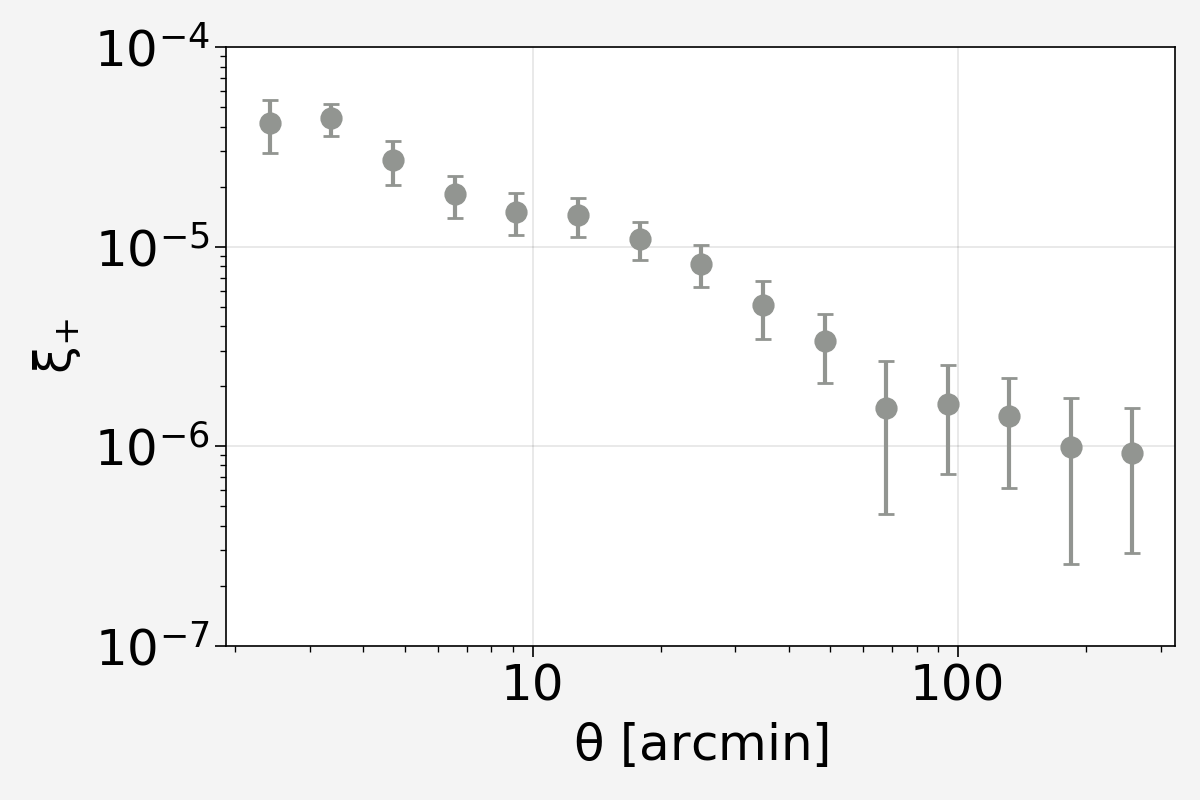

In [47]:
matplotlib.rcParams.update({'font.size':18, 'legend.fontsize':'medium', 'lines.markersize':7, "text.usetex": False, "font.family": "serif", "font.serif": ["Times New Roman"]})
fig,ax = pplt.subplots(figsize=(6,4))

ax.errorbar(xi_sv[:15,0], xi_sv[:15,1], yerr=np.sqrt(np.diag(xi_cov[:15, :15])), fmt='o', c='grey', label='SV')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-7,1e-4)
ax.format(yticklabels=['','$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$',])
ax.set_xlabel(r'$\theta$ [arcmin]')
ax.set_ylabel(r'$\xi_{+}$')

In [37]:
np.diag(xi_cov[:15, :15])

array([1.54509129e-10, 6.56084862e-11, 4.55936359e-11, 1.97234274e-11,
       1.21453180e-11, 1.03063213e-11, 5.46703751e-12, 3.82152233e-12,
       2.74616655e-12, 1.59497325e-12, 1.22408310e-12, 8.23658114e-13,
       6.27500679e-13, 5.46194701e-13, 3.93519032e-13])

In [37]:
nz_y3 = np.loadtxt('/pscratch/sd/m/myamamot/sample_variance/Y3_nontomographic_nz.txt')
nz_sv = np.loadtxt('/pscratch/sd/m/myamamot/y6-cosmicshear/ngmix_skynet_pz.dat')
nz_y6 = fio.read('/pscratch/sd/m/myamamot/y6-cosmicshear/2pt_modal_even_y6_test_smooth_1bin.fits')

import h5py as h5
f = h5.File('/global/cfs/cdirs/des/www/y3_cats/Y3_mastercat___UNBLIND___final_v1.1_12_22_20.h5', 'r')
m = np.array(f.get('/index/select'))
pzdata = f.get('/catalog/sompz/pzdata')

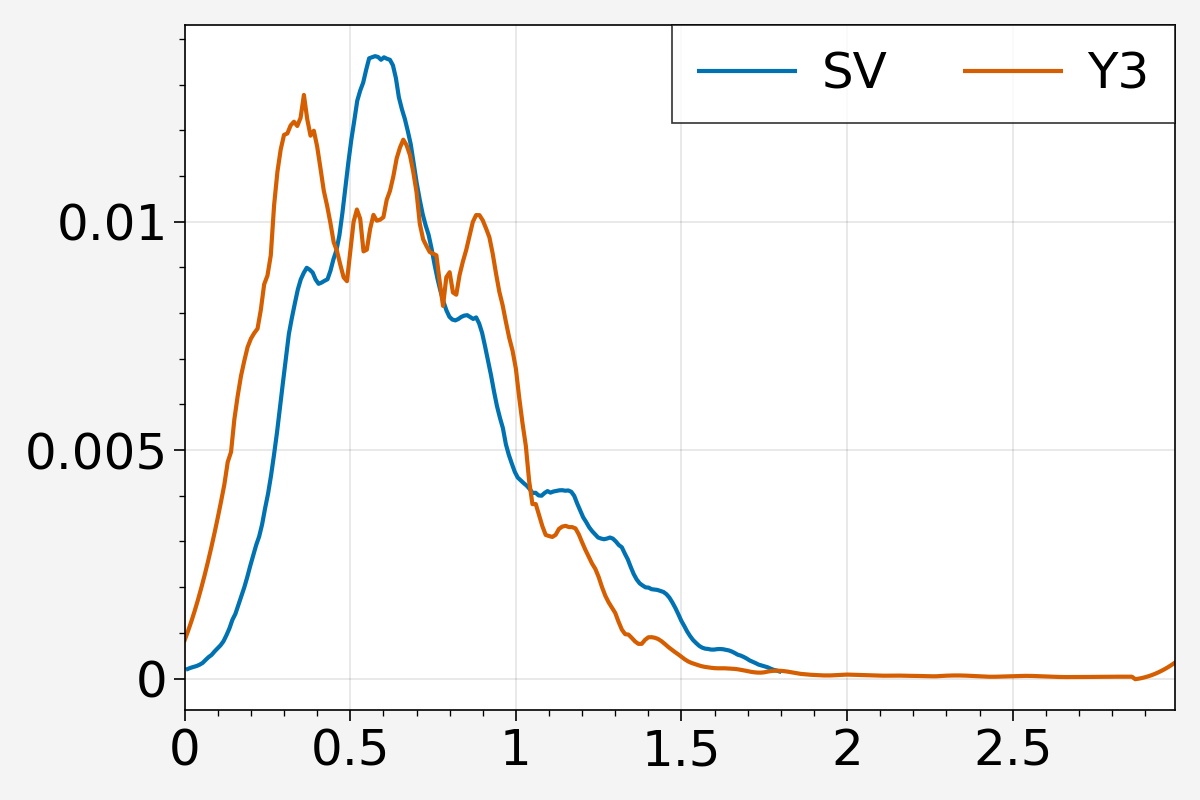

In [35]:
matplotlib.rcParams.update({'font.size':18, 'legend.fontsize':'medium', 'lines.markersize':7, "text.usetex": False, "font.family": "serif", "font.serif": ["Times New Roman"]})
fig,ax = pplt.subplots(figsize=(6,4))

ax.plot((nz_sv[:,0]+nz_sv[:,1])/2., nz_sv[:,5], label='SV')
ax.plot(nz_y3[:,0], nz_y3[:,1]/np.sum(nz_y3[:,1]), label='Y3')
ax.legend()